In [2]:
import os
import sys
import re
import shutil
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.cross_validation import StratifiedKFold
from collections import Counter
from itertools import product
import operator
import string

import numpy as np
import pandas as pd

In [3]:
sys.path.insert(1,'/root/artm/python')

In [4]:
import artm

In [5]:
os.environ["ARTM_SHARED_LIBRARY"] = "/root/artm/build/lib/libartm.so"

In [8]:
%%bash
git clone https://github.com/python-telegram-bot/python-telegram-bot
cd python-telegram-bot
python setup.py install

Cloning into 'python-telegram-bot'...


In [ ]:
%%bash
git clone https://github.com/soboleva-daria/pyloggers.git
cd pyloggers/ && git pull

In [5]:
sys.path.insert(1,'pyloggers')
from telegram_logger import TelegramLogger
tl = TelegramLogger(name='artm')

In [6]:
data_dir = 'data_ekg'
file_src = 'vw.txt'
n_obj = 372

n_shuffle = 10
n_folds = 10

In [7]:
# Инициализация фи

def freq_count(line, docs_freq, docs_freq3):
    n = 6
    k = 3
    l = line.split(' ',1)
    d = l[0]

    l = l[1].split('|', 1)

    cls = "%s "%(l[1].strip())
    cls = re.findall(r'\:(.*?)\ ', cls)

    if int(cls[1]): # с - класс больных ХХ
        return docs_freq, docs_freq3

    docs_freq3[d] = []
    docs_freq[d] = dict.fromkeys(string.ascii_uppercase[:n], 0)
    
    for w in l[0].split():
        docs_freq3[d].append(int(w[k + 1:]))

        for key, value in Counter(w[:k]).items():
            docs_freq[d][key] += value * int(w[k + 1:])
            
    return docs_freq, docs_freq3

In [7]:
def separate_fold_for_cv(n_shuffle, n_folds):

    # Инициализация фи
    #docs_freq = {}
    #docs_freq3 = {}

    with open('vw_true_labels{}.txt'.format(n_shuffle), 'r') as fin:
        y_true = np.array([int(i) for i in fin.readlines()], dtype=str)
    skf = StratifiedKFold(y_true, n_folds)

    with open('vw{}.txt'.format(n_shuffle), 'r') as fin:
        data = np.array(fin.readlines())

    for n_fold, (i, j) in enumerate(skf):

        d_dir = '{}/data{}'.format(data_dir, n_fold)
        os.mkdir(d_dir)
        with open(os.path.join(d_dir, 'test.txt'), 'w') as test:
            with open(os.path.join(d_dir, 'true_labels.txt'), 'w') as label:
                with open(os.path.join(d_dir, 'train.txt'), 'w') as train:

                    train.write(''.join(data[i]))
                    label.write('\n'.join(y_true[j]))

                    for line in data[j]:
                        test.write("%s\n" % (line.partition('|')[0]))

    # return docs_freq, docs_freq3

In [8]:
def create_batches(n_fold):
    batch_vectorize = None
    d_dir = '{}/data{}'.format(data_dir, n_fold)
    
    new_folder = os.path.join(d_dir, 'data_batches')
    target_folder_train = "%s%s" % (new_folder, '_train')
    target_folder_test = "%s%s" % (new_folder, '_test')

    batch_vectorizer = artm.BatchVectorizer(
        batch_size=100000,
        data_path=os.path.join(
            d_dir,
            'train.txt'),
        data_format='vowpal_wabbit',
        target_folder=target_folder_train)

    batch_vectorizer = artm.BatchVectorizer(
        batch_size=100000,
        data_path=os.path.join(
            d_dir,
            'test.txt'),
        data_format='vowpal_wabbit',
        target_folder=target_folder_test)

    os.rename(
        os.path.join(
            target_folder_train,
            'aaaaaa.batch'),
        os.path.join(
            target_folder_train,
            'train.batch'))

    os.rename(
        os.path.join(
            target_folder_test,
            'aaaaaa.batch'),
        os.path.join(
            target_folder_test,
            'test.batch'))

    folder_for_dict = os.path.join(d_dir, 'for_dict')
    os.mkdir(folder_for_dict)

    shutil.copy(
        os.path.join(
            target_folder_train,
            'train.batch'),
        folder_for_dict)

    shutil.copy(
        os.path.join(
            target_folder_test,
            'test.batch'),
        folder_for_dict)
    
    shutil.copy(os.path.join(d_dir, 'true_labels.txt'), target_folder_test)

In [10]:
def trigrams():
    tokens = []
    for token in product(string.ascii_uppercase, repeat=3):

        if token[0] > 'F':
            break

        if token[1] > 'F' or token[2] > 'F':
            continue

        tokens.append(''.join(token))
    return tokens

def build_phi(n_topics, docs_freq, docs_freq3):

    # Подсчет КГ
    for key, value in docs_freq.items():
        n = 0
        for k in {'A', 'B', 'E', 'F'}:
            n += value[k]
        docs_freq[key] = float(n) / (value['C'] + value['D']) or 1

    # Сортировка по КГ
    list_docs = []
    for key in sorted(docs_freq, key=docs_freq.__getitem__):
        list_docs.append(docs_freq3[key])

    # Разбиваем на корзинки, число корзинок == n_topics
    buckets = np.array_split(np.array(list_docs), n_topics)

    # Усредняем по корзинкам
    p_wt = []
    for bucket in buckets:
        p_wt.append(np.mean(bucket, axis=0))
    p_wt = np.array(p_wt, dtype=float).T
    
    # p(label1|t) = 1
    p_wt = np.vstack((p_wt, np.ones(n_topics)))

    # p(label0|t) = 0
    p_wt = np.vstack((p_wt, np.zeros(n_topics)))

    # Рандомизируем
    rand = np.random.poisson(lam=1.0, size=(bucket.shape[1], n_topics))
    rand = np.vstack((rand, np.random.poisson(lam=10, size=(2, n_topics))))
    p_wt += rand
    
    # Нормируем
    p_wt = np.divide(p_wt, p_wt.sum(axis=0))
    
    w = trigrams()
    w.extend(['label1', 'label0'])
    topics = ['topic_{}'.format(i) for i in range(n_topics)]

    return pd.DataFrame(p_wt, index=w, columns=topics)

In [130]:
n_topics = 7
n_tokens = 218

n_collection_passes = 60
n_document_passes = 1 #np.ones(n_collection_passes, dtype=int)

#labels_class_weight = [1]*num_collection_passes
tau   = np.repeat([1, 10, 100, 1000, 1e4, 1e5], 10)
#tau = np.append(tau, np.repeat([1e5], 5))
min_tau = int(min(tau))
max_tau = int(max(tau))
w_gram3 = np.ones(n_collection_passes)

c ='labels'
gram3 = '@default_class'

scores_folds_iter  = {}
perplexity_c = {}
perplexity_gram3 = {}
sparsity_phi_c = {}
sparsity_phi_gram3 = {}

for i in range(n_collection_passes):
    scores_folds_iter[i] = []
    perplexity_c[i] = []
    perplexity_gram3[i] = []
    sparsity_phi_c[i] = []
    sparsity_phi_gram3[i] = []
    
src = 'topics{}_tau{}_{}'.format(n_topics, min_tau, max_tau)
theta_dir = 'theta_' + src
ptc_dir =   'ptc_' + src
os.mkdir(theta_dir)
os.mkdir(ptc_dir)

In [6]:
# n_shuffle * n_folds - cv

def reject_shuffle(strings, n):
    orders = set()
    e_strings = list(enumerate(strings))
    for gen_idx in range(n):    
        while tuple([idx for idx, _ in e_strings]) in orders:
              np.random.shuffle(e_strings)
        orders.update((tuple([idx for idx, _ in e_strings]),))
        yield [val for _, val in e_strings]

        
y_true = []
with open(file_src, 'r') as fin:
    lines = fin.readlines()
    
    for gen_idx, shuffled in enumerate(reject_shuffle(lines, n_shuffle)):
        for line in shuffled:
            line_tmp = "%s " % (line.split('|', 1)[1][:-1])
            str_tmp = re.findall(r'\:(.*?)\ ', line_tmp)
            y_true.append(str_tmp[1])
            
        with open('vw_true_labels{}.txt'.format(gen_idx), 'w') as fout:
            fout.write('\n'.join(y_true))
            
        with open('vw{}.txt'.format(gen_idx), 'w') as fout:
            fout.write(''.join(shuffled))

In [10]:
n_shuffle = 0
n_folds = 10

separate_fold_for_cv(n_shuffle, n_folds)

In [97]:
create_batches(0)

In [12]:
n_topics = 2
n_document_passes = 1
n_collection_passes = 60

In [13]:
# true_p_cd = np.asarray(n_fold)
n_fold = 0

d_dir = '{}/data{}'.format(data_dir, n_fold)

batch_vectorizer_fit = artm.BatchVectorizer(
    data_path=os.path.join(
        d_dir,
        'data_batches_train'),
    data_format="batches")
batch_vectorizer_test = artm.BatchVectorizer(
    data_path=os.path.join(
        d_dir,
        'data_batches_test'),
    data_format="batches")

dictionary = artm.Dictionary()
dictionary.gather(data_path=os.path.join(d_dir, 'for_dict'))

model = artm.ARTM(
    num_topics=n_topics,
    dictionary=dictionary,
    cache_theta=True,
    reuse_theta=True)

model.scores.add(artm.PerplexityScore(name='perplexity_score_c',
                                      class_ids = ['labels'], 
                                      dictionary=dictionary))

model.scores.add(artm.PerplexityScore(name='perplexity_score_gram3',
                                      class_ids = ['@default_class'], 
                                      dictionary=dictionary))

# Разреженность p(c|t) аналогична разреженности p(t|c)
model.scores.add(
    artm.SparsityPhiScore(
        name='sparsity_phi_score_c',
        class_id='labels'))

# Разреженность p(w|t)
model.scores.add(
    artm.SparsityPhiScore(
        name='sparsity_phi_score_gram3',
        class_id='@default_class'))

model.num_document_passes = n_document_passes
# Регуляризатор разреженности p(c|t)
# model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer'))
# model.regularizers['sparse_phi_regularizer'].tau = -1.0
# model.regularizers['sparse_phi_regularizer'].class_ids = 'labels'

In [19]:
scores_folds_iter  = {}
perplexity_c = {}
perplexity_gram3 = {}
sparsity_phi_c = {}
sparsity_phi_gram3 = {}

for i in range(n_collection_passes):
    scores_folds_iter[i] = []
    perplexity_c[i] = []
    perplexity_gram3[i] = []
    sparsity_phi_c[i] = []
    sparsity_phi_gram3[i] = []

In [20]:
w_gram3 = np.ones(n_collection_passes)
tau   = np.repeat([1, 10, 100, 1000, 1e4, 1e5], 10)
c ='labels'
gram3 = '@default_class'

In [36]:
%%time
cols = ['doc{}'.format(i) for i in range (test_theta.shape[1] - 1)]
cols.insert(0, 'index')

CPU times: user 18 µs, sys: 31 µs, total: 49 µs
Wall time: 55.1 µs


In [35]:
%%time
cols = ['doc{}'.format(i) for i in range (test_theta.shape[1] - 1)]
cols = ['index'] + cols

CPU times: user 25 µs, sys: 44 µs, total: 69 µs
Wall time: 73 µs


In [21]:
for n_iter in xrange(n_collection_passes):

    model.class_ids = {
        gram3: w_gram3[n_iter],
        c: tau[n_iter]}

    model.fit_offline(
        num_collection_passes=1,
        batch_vectorizer=batch_vectorizer_fit)

    perplexity_c[n_iter].append(
        model.score_tracker['perplexity_score_c'].last_value)

    perplexity_gram3[n_iter].append(
        model.score_tracker['perplexity_score_gram3'].last_value)

    sparsity_phi_c[n_iter].append(
        model.score_tracker['sparsity_phi_score_c'].last_value)

    sparsity_phi_gram3[n_iter].append(
        model.score_tracker['sparsity_phi_score_gram3'].last_value)

    break

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [40]:
test_theta = model.transform(
    batch_vectorizer=batch_vectorizer_test,
    predict_class_id='labels').reset_index()

cols = ['doc{}'.format(i) for i in range (test_theta.shape[1] - 1)]
cols.insert(0, 'index')
test_theta.columns = cols

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [45]:
test_theta[test_theta['index'] == 'label1'][docs].values

array([[ 0.61316514,  0.60851097,  0.60393518,  0.62568569,  0.60075891,
         0.61543214,  0.62937123,  0.61274517,  0.60699934,  0.59381074,
         0.61546677,  0.61443806,  0.59517705,  0.60057259,  0.62105119,
         0.62129676,  0.61516041,  0.59226847,  0.62811613,  0.63396972,
         0.62541968,  0.59320492,  0.57759237,  0.58578968,  0.62421173,
         0.6035471 ,  0.62141633,  0.61014259,  0.6093511 ,  0.62469697,
         0.60081267,  0.6057936 ,  0.62465799,  0.62304384,  0.60242838,
         0.6233831 ,  0.61697829,  0.61272353]], dtype=float32)

In [ ]:
with open('data_ekg/data0/true_labels.txt' 'r') as fin:
    y_true = [fin.readlines()

In [46]:
roc_auc_score()

In [131]:
for i in xrange(n_shuffle):
    os.mkdir(data_dir)
    #docs_freq, docs_freq3 = 
    separate_fold_for_cv(i, n_folds)
    
    for n_fold in range(n_folds):
        create_batches(n_fold)

    #test_labels_file = os.path.join(data_dir, 'true_labels.txt')
    #true_p_cd = []
    #with open(test_labels_file, 'r') as fin:
    #    for line in fin.readlines():
    #        if int(line.split(" ")[0]):
    #            true_p_cd.append(0)
    #        else:
    #            true_p_cd.append(1)

    # true_p_cd = np.asarray(true_p_cd)

    batch_vectorizer_fit = artm.BatchVectorizer(
        data_path=os.path.join(
            data_dir,
            'data_batches_train'),
        data_format="batches")
    batch_vectorizer_test = artm.BatchVectorizer(
        data_path=os.path.join(
            data_dir,
            'data_batches_test'),
        data_format="batches")

    dictionary = artm.Dictionary()
    dictionary.gather(data_path=os.path.join(data_dir, 'for_dict'))

    model = artm.ARTM(
        num_topics=n_topics,
        dictionary=dictionary,
        cache_theta=True,
        reuse_theta=True)

    # Инициализация
    #(_, phi_ref) = model.master.attach_model(model=model.model_pwt)
    #phi_new = build_phi(n_topics, docs_freq, docs_freq3)
    
    #ind = list(model.get_phi(model_name=model.model_pwt).reset_index()['index'])
    #phi_new = phi_new.reindex(ind).as_matrix()
    
    #for tok in xrange(n_tokens):
    #    for top in xrange(n_topics):
    #        phi_ref[tok, top] = phi_new[tok, top]

    # Перплексия
    #model.scores.add(artm.PerplexityScore(name='perplexity_score',
    #                                      use_unigram_document_model=False,
    #                                      dictionary=dictionary))
    
    model.scores.add(artm.PerplexityScore(name='perplexity_score_c',
                                          class_ids = ['labels'], 
                                          use_unigram_document_model=False,
                                          dictionary=dictionary))
    
    model.scores.add(artm.PerplexityScore(name='perplexity_score_gram3',
                                          class_ids = ['@default_class'], 
                                          use_unigram_document_model=False,
                                          dictionary=dictionary))
    
    # Разреженность p(c|t) аналогична разреженности p(t|c)
    model.scores.add(
        artm.SparsityPhiScore(
            name='sparsity_phi_score_c',
            class_id='labels'))
    
    # Разреженность p(w|t)
    model.scores.add(
        artm.SparsityPhiScore(
            name='sparsity_phi_score_gram3',
            class_id='@default_class'))
    
    model.num_document_passes = n_document_passes
    # Регуляризатор разреженности p(c|t)
    # model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer'))
    # model.regularizers['sparse_phi_regularizer'].tau = -1.0
    # model.regularizers['sparse_phi_regularizer'].class_ids = 'labels'

    for n_iter in xrange(n_collection_passes):

        model.class_ids = {
            gram3: w_gram3[n_iter],
            c: tau[n_iter]}

        model.fit_offline(
            num_collection_passes=1,
            batch_vectorizer=batch_vectorizer_fit)

        perplexity_c[n_iter].append(
            model.score_tracker['perplexity_score_c'].last_value)
        
        perplexity_gram3[n_iter].append(
            model.score_tracker['perplexity_score_gram3'].last_value)

        sparsity_phi_c[n_iter].append(
            model.score_tracker['sparsity_phi_score_c'].last_value)
        
        sparsity_phi_gram3[n_iter].append(
            model.score_tracker['sparsity_phi_score_gram3'].last_value)

        test_theta = model.transform(
            batch_vectorizer=batch_vectorizer_test,
            predict_class_id='labels').reset_index()
        d = 'doc{}'.format(index)
        test_theta.columns = ['index', d]
        scores_folds_iter[n_iter].append(
            float(test_theta[test_theta['index'] == 'label1'][d]))

    test_theta.to_csv(
        os.path.join(
            theta_dir,
            "test_theta{}.csv".format(index)))

    # p(t|c)
    theta = model.get_theta()
    p_d = 1.0 / (n_obj - 1)
    p_t = theta
    p_t = p_t.multiply(p_d)
    p_t = p_t.sum(axis=1)

    phi = model.get_phi().reset_index()
    p_ct = phi[(phi['index'] == 'label0') | (
        phi['index'] == 'label1')].set_index('index')
    p_ct = p_ct.multiply(p_t)
    p_tc = p_ct.div(p_ct.sum(axis=1), axis='index').T

    p_tc.to_csv(os.path.join(ptc_dir, "p_tc{}.csv".format(index)))
    
    shutil.rmtree(data_dir)
    tl.push('done{}'.format(index))

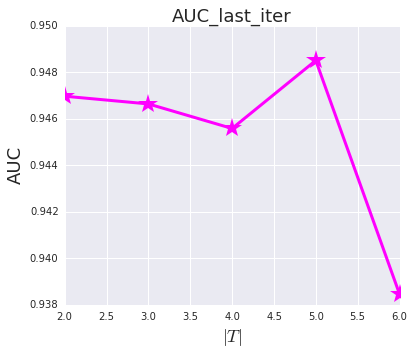

In [132]:
# Последняя итерация
figure(figsize=(6, 5))
auc_last_iter = []
topics_list = [2, 3, 4, 5, 6]
max_tau = 100000

file_src = 'auc_topics{}_tau{}_10000'.format(2, min_tau)
with open(file_src + '.txt', 'r') as fin:
    auc_last_iter.append([float(line) for line in fin.readlines()][-1])
        
for i in range(3, 7):
    file_src = 'auc_topics{}_tau{}_{}'.format(i, min_tau, max_tau)
    with open(file_src + '.txt', 'r') as fin:
        auc_last_iter.append([float(line) for line in fin.readlines()][-1])

plot(np.array(topics_list, dtype=int), auc_last_iter, color='magenta', marker='*', markersize=20,  lw=3)
xlabel("$|T|$", fontsize=18)
ylabel('AUC', fontsize=18)
title('AUC_last_iter', fontsize=18)
#xlim(topics_list[-1])
#xticks(np.arange(min(x), max(x)+1, 7))
    #text(27, 200, '$|T|=2$', fontsize=18)
    #text(27, 190, r'$ \tau \in range(1, 1e4, 10)$',  fontsize=18)
    #text(35, 23, '$W^t=1$', fontsize=18)
#savefig(file_src + '.eps', format = 'eps')
#savefig('perplexity_{}_topics_wc_{}_tokens.png'.format(n_topics, w_c))
show()

Populating the interactive namespace from numpy and matplotlib


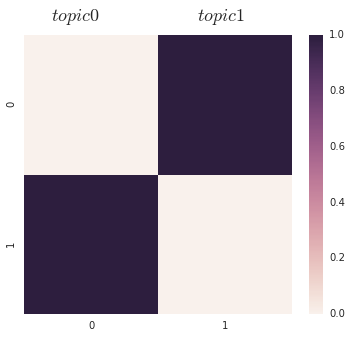

In [129]:
import seaborn as sns
%pylab inline
figure(figsize=(6, 5))
p_tc = pd.read_csv('p_tc_topics2_tau1_10000.csv', index_col=0)
sns.heatmap(p_tc.as_matrix())
text(0.2, 2.1, '$topic0$', fontsize=18)
text(1.29, 2.1, '$topic1$', fontsize=18)
#text(0.0001, 1.5, '$label0$', fontsize=18, rotation='vertical')
#title('p(t|c)', fontsize=20)
savefig('p_tc_topics2_tau1_10000.eps', format = 'eps')
show()

In [94]:
# Правильные ответы

true_p_cd = []
with open ('vw.txt', 'r') as fin:
    for index, line in enumerate(fin.readlines()):
        line_ = "%s "%(line.split('|',1)[1][:-1])
        str_ = re.findall(r'\:(.*?)\ ', line_)
        
        if int(str_[0]):
            true_p_cd.append(0)
        else:
            true_p_cd.append(1)

In [96]:
# Перплексия. gram3
f = 'perplexity_topics{}_tau{}_{}_gram3.txt'.format(n_topics, min_tau, max_tau)

with open(f, 'w') as fout:
    for n_iter, value in perplexity_gram3.items():
        fout.write("{}\n".format(np.mean(value)))

# Перплексия. labels
f = 'perplexity_topics{}_tau{}_{}_c.txt'.format(n_topics, min_tau, max_tau)

with open(f, 'w') as fout:
    for n_iter, value in perplexity_c.items():
        fout.write("{}\n".format(np.mean(value)))

In [97]:
# Разреженность. gram3
f = 'sparsity_topics{}_tau{}_{}_gram3.txt'.format(n_topics, min_tau, max_tau)

with open(f, 'w') as fout:
    for n_iter, value in sparsity_phi_gram3.items():
        fout.write("{}\n".format(np.mean(value)))

# Разреженность. labels
f = 'sparsity_topics{}_tau{}_{}_c.txt'.format(n_topics, min_tau, max_tau)

with open(f, 'w') as fout:
    for n_iter, value in sparsity_phi_c.items():
        fout.write("{}\n".format(np.mean(value)))

In [98]:
# p(t|c)

src = os.path.join(ptc_dir, 'p_tc{}.csv'.format(0))
p_tc_mean = pd.read_csv(src, index_col=0).as_matrix()

for i in range(1, n_obj):
    src = os.path.join(ptc_dir, 'p_tc{}.csv'.format(i))
    p_tc_mean += pd.read_csv(src, index_col=0).as_matrix()

p_tc_mean /= float(n_obj)

pd.DataFrame(
    p_tc_mean, index=[
        'topic{}'.format(i) for i in range(n_topics)],
    columns=['label0', 'label1']).to_csv(
    'p_tc_topics{}_tau{}_{}.csv'.format(
        n_topics, min_tau, max_tau))

In [99]:
# p(c|d). LogLoss

src = os.path.join(theta_dir, 'test_theta{}.csv'.format(0)) 
p_cd = pd.read_csv(src, index_col=0)

for i in range(1, n_obj):
    src = os.path.join(theta_dir, 'test_theta{}.csv'.format(i)) 
    d = 'doc{}'.format(i)
    p_cd[d] = pd.read_csv(src, index_col=0)[d]
    
docs = [col_name for col_name in p_cd.columns if col_name != 'index']
p_cd = p_cd[p_cd['index'] == 'label1'][docs].T[1].tolist()
logloss = log_loss(true_p_cd, p_cd)

In [100]:
# n_topics = 6; tau in (1, 1e5, 10)

logloss

0.51070031739192756

In [60]:
# n_topics = 5; tau in (1, 1e5, 10)

logloss

0.54186559594112138

In [34]:
# n_topics = 4; tau in (1, 1e5, 10)

logloss

0.50041592207298435

In [44]:
# n_topics = 3; tau in (1, 1e5, 10)

logloss

0.57280594889530834

In [143]:
# n_topics = 2; tau in (1, 1e4, 10)

logloss

0.49179636714696534

In [95]:
# AUC

iters = [n_iter + 1 for n_iter in scores_folds_iter.keys()]

auc_scores = [
    roc_auc_score(
        np.asarray(true_p_cd),
        np.asarray(value)) for key,
    value in scores_folds_iter.iteritems()]

f = 'auc_topics{}_tau{}_{}.txt'.format(n_topics, min_tau, max_tau)
with open(f, 'w') as fout:
    for score in auc_scores:
        fout.write('{}\n'.format(score))